In [49]:
import pandas as pd
tekme_redne = pd.read_csv('statistika-v-csv/tekme_redne.csv', index_col='Tekma',encoding = "utf-8")
tekme_playoff = pd.read_csv('statistika-v-csv/tekme_playoff.csv', index_col='Tekma',encoding = "utf-8")
ekipe = pd.read_csv('statistika-v-csv/ekipe.csv', index_col='id',encoding = "utf-8")
pd.options.display.max_rows = 10
%matplotlib inline

In [50]:
tekme_redne = tekme_redne[tekme_redne.Team != 31] #izbrišemo All-Star tekmo
tekme_redne = tekme_redne[tekme_redne.Team != 32]
ekipe = ekipe.drop([31,32]) #izbrišemo All-Star ekipi
tekme_redne[["FGM", "FGA"]] = tekme_redne["FG"].str.split("-", expand = True)
tekme_redne[["3PM", "3PA"]] = tekme_redne["3PT"].str.split("-", expand = True)
tekme_redne[["FTM", "FTA"]] = tekme_redne["FT"].str.split("-", expand = True)
tekme_playoff[["FGM", "FGA"]] = tekme_playoff["FG"].str.split("-", expand = True)
tekme_playoff[["3PM", "3PA"]] = tekme_playoff["3PT"].str.split("-", expand = True)
tekme_playoff[["FTM", "FTA"]] = tekme_playoff["FT"].str.split("-", expand = True)
tekme_redne = tekme_redne.drop(columns=['FG','3PT','FT'])
tekme_playoff = tekme_playoff.drop(columns=['FG','3PT','FT'])


In [51]:
tekme_redne = tekme_redne.astype(float)
tekme_playoff = tekme_playoff.astype(float)

In [52]:
tekme_redne["FG%"] = 100 * tekme_redne["FGM"]/tekme_redne["FGA"]
tekme_redne["3P%"] = 100 * tekme_redne["3PM"]/tekme_redne["3PA"]
tekme_redne["FT%"] = 100 * tekme_redne["FTM"]/tekme_redne["FTA"]
tekme_playoff["FG%"] = 100 * tekme_playoff["FGM"]/tekme_playoff["FGA"]
tekme_playoff["3P%"] = 100 * tekme_playoff["3PM"]/tekme_playoff["3PA"]
tekme_playoff["FT%"] = 100 * tekme_playoff["FTM"]/tekme_playoff["FTA"]

In [53]:
tekme_redne["FG%"] = tekme_redne["FG%"].round(decimals=2)
tekme_redne["3P%"] = tekme_redne["3P%"].round(decimals=2)
tekme_redne["FT%"] = tekme_redne["FT%"].round(decimals=2)
tekme_playoff["FG%"] = tekme_playoff["FG%"].round(decimals=2)
tekme_playoff["3P%"] = tekme_playoff["3P%"].round(decimals=2)
tekme_playoff["FT%"] = tekme_playoff["FT%"].round(decimals=2)

In [54]:
zmaga_poraz_redne = []

for i in range(tekme_redne["PTS"].size):
    if i % 2 == 0:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i + 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)
    else:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i - 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)

tekme_redne["W/L"] = zmaga_poraz_redne

zmaga_poraz_playoff = []

for i in range(tekme_playoff["PTS"].size):
    if i % 2 == 0:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i + 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)
    else:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i - 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)

tekme_playoff["W/L"] = zmaga_poraz_playoff

In [55]:
ekipe_redno_2 = tekme_redne.groupby("Team")
ekipe_playoff_2 = tekme_playoff.groupby("Team")
ekipe_redno = ekipe_redno_2.sum()
ekipe_playoff = ekipe_playoff_2.sum()

In [56]:
ekipe_redno["FG%"] = ekipe_redno["FG%"]/ekipe_redno_2.count()["FG%"]
ekipe_redno["3P%"] = ekipe_redno["3P%"]/ekipe_redno_2.count()["3P%"]
ekipe_redno["FT%"] = ekipe_redno["FT%"]/ekipe_redno_2.count()["FT%"]
ekipe_playoff["FG%"] = ekipe_playoff["FG%"]/ekipe_playoff_2.count()["FG%"]
ekipe_playoff["3P%"] = ekipe_playoff["3P%"]/ekipe_playoff_2.count()["3P%"]
ekipe_playoff["FT%"] = ekipe_playoff["FT%"]/ekipe_playoff_2.count()["FT%"]
ekipe_redno["3PA/FGA"] = ekipe_redno["3PA"]/ekipe_redno["FGA"]
ekipe_playoff["3PA/FGA"] = ekipe_playoff["3PA"]/ekipe_playoff["FGA"]

In [57]:
ekipe_redno = ekipe_redno.rename(columns={"W/L" : "WINS"})
ekipe_playoff =ekipe_playoff.rename(columns={"W/L" : "WINS"})
ekipe_redno["WIN%"] = 100 * ekipe_redno["WINS"]/ekipe_redno_2.count()["W/L"]
ekipe_playoff["WIN%"] = 100 * ekipe_playoff["WINS"]/ekipe_playoff_2.count()["W/L"]

In [58]:
lestvica_redno = ekipe_redno.sort_values(by='WIN%',ascending=False)
najvec_relativno_za_tri_redno = ekipe_redno.sort_values(by='3PA/FGA',ascending=False)

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razmerje metov za tri in vseh metov na koš', ylabel='Delež zmag izmed vseh tekem [%]'>

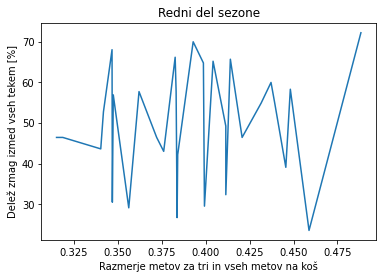

In [74]:
import matplotlib.pyplot as plt

lestvica_redno.groupby("3PA/FGA")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Razmerje metov za tri in vseh metov na koš", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri [%]', ylabel='Delež zmag izmed vseh tekem [%]'>

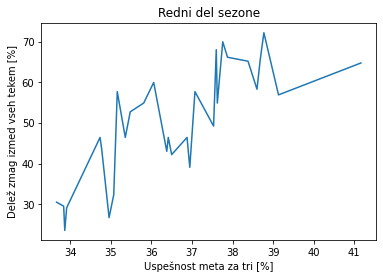

In [75]:
lestvica_redno.groupby("3P%")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Uspešnost meta za tri [%]", ylabel="Delež zmag izmed vseh tekem [%]")

In [72]:
razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
razlika_v_metu_za_tri = []

for i in range(tekme_redne["3P%"].size//2):
    if tekme_redne["W/L"].iloc[2 * i] == 1:
        razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i] - tekme_redne["3P%"].iloc[2 * i + 1])
        razlika_v_metu_za_tri.append(100* (tekme_redne["3PA"].iloc[2 * i]/tekme_redne["FGA"].iloc[2 * i] - tekme_redne["3PA"].iloc[2 * i + 1]/tekme_redne["FGA"].iloc[2 * i + 1]))
    else:
        razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i + 1] - tekme_redne["3P%"].iloc[2 * i])
        razlika_v_metu_za_tri.append(100* (tekme_redne["3PA"].iloc[2 * i + 1]/tekme_redne["FGA"].iloc[2 * i + 1] - tekme_redne["3PA"].iloc[2 * i]/tekme_redne["FGA"].iloc[2 * i]))
    
    razlika_v_tockah.append(abs(tekme_redne["PTS"].iloc[2 * i] - tekme_redne["PTS"].iloc[2 * i + 1]))

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3PA/FGA DIFF" : razlika_v_metu_za_tri}
tekme_redne2 = pd.DataFrame(data)
tekme_redne2 = tekme_redne2.rename_axis(index="Tekma")

razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
razlika_v_metu_za_tri = []

for i in range(tekme_playoff["3P%"].size//2):
    if tekme_playoff["W/L"].iloc[2 * i] == 1:
        razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i] - tekme_playoff["3P%"].iloc[2 * i + 1])
        razlika_v_metu_za_tri.append(100* (tekme_playoff["3PA"].iloc[2 * i]/tekme_playoff["FGA"].iloc[2 * i] - tekme_playoff["3PA"].iloc[2 * i + 1]/tekme_playoff["FGA"].iloc[2 * i + 1]))
    else:
        razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i + 1] - tekme_playoff["3P%"].iloc[2 * i])
        razlika_v_metu_za_tri.append(100* (tekme_playoff["3PA"].iloc[2 * i + 1]/tekme_playoff["FGA"].iloc[2 * i + 1] - tekme_playoff["3PA"].iloc[2 * i]/tekme_playoff["FGA"].iloc[2 * i]))
    
    razlika_v_tockah.append(abs(tekme_playoff["PTS"].iloc[2 * i] - tekme_playoff["PTS"].iloc[2 * i + 1]))

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3PA/FGA DIFF" : razlika_v_metu_za_tri}
tekme_playoff2 = pd.DataFrame(data)
tekme_playoff2 = tekme_playoff2.rename_axis(index="Tekma")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]', ylabel='Prednost zmagovalca na koncu tekme'>

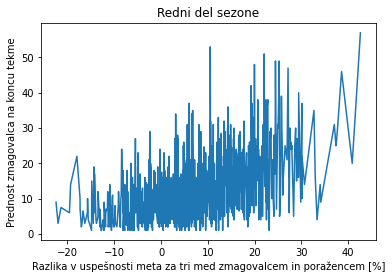

In [77]:
tekme_redne2.groupby("3P% DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]", ylabel="Prednost zmagovalca na koncu tekme")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]', ylabel='Prednost zmagovalca na koncu tekme'>

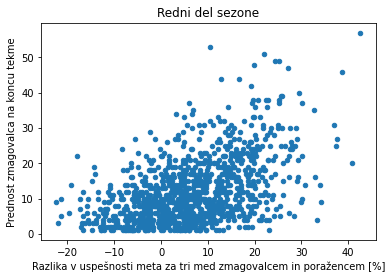

In [83]:
tekme_redne2.plot.scatter("3P% DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]", ylabel="Prednost zmagovalca na koncu tekme")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov med zmagovalcem in poražencem [%]', ylabel='Prednost zmagovalca na koncu tekme'>

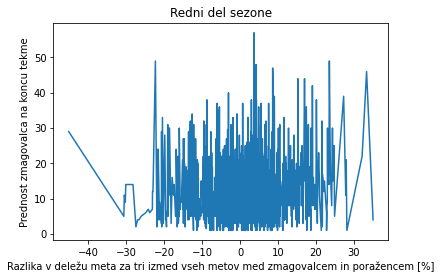

In [79]:
tekme_redne2.groupby("3PA/FGA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov med zmagovalcem in poražencem [%]", ylabel="Prednost zmagovalca na koncu tekme")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov med zmagovalcem in poražencem [%]', ylabel='Prednost zmagovalca na koncu tekme'>

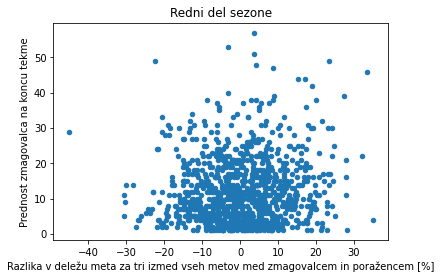

In [84]:
tekme_redne2.plot.scatter("3PA/FGA DIFF", "PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov med zmagovalcem in poražencem [%]", ylabel="Prednost zmagovalca na koncu tekme")